In [2]:
import torch
import matplotlib.pyplot as plt
from utils.defects import S_cal
import numpy as np

from kinetic_solver import KineticSolver, KineticData
from nematic_env import ActiveNematicEnv

In [ ]:
t = 50
print('t = ', t)

In [ ]:
def _action2light(self_intensity, action, grid_size=256):
    # 确保 action 在 GPU 上是 PyTorch 张量
    if not isinstance(action, torch.Tensor):
        action = torch.tensor(action, device="cuda")
    
    # 1. 计算椭圆的参数
    x_center = ((action[0] + 1) / 2 * grid_size).int()  # 椭圆平移后的中心x坐标
    y_center = ((action[1] + 1) / 2 * grid_size).int()  # 椭圆平移后的中心y坐标
    a = (action[2] + 1) / 2 * grid_size / 2             # 长轴，假设范围是 [10, 60]
    b = (action[3] + 1) / 2 * grid_size / 2             # 短轴，假设范围是 [5, 35]
    theta = (action[4] + 1) / 2 * 2 * torch.pi          # 方向角范围 [0, 2π]
    intensity = (action[5] + 1) / 2 * self_intensity    # 光照强度范围 [0, intensity]

    # 2. 构建网格坐标，并以中心为原点放置椭圆
    y, x = torch.meshgrid(torch.arange(grid_size, device="cuda"), torch.arange(grid_size, device="cuda"))
    x_shifted = x - grid_size // 2  # 平移椭圆初始位置到正中心
    y_shifted = y - grid_size // 2

    # 3. 旋转椭圆的角度变换
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    # 旋转后的坐标
    x_rotated = x_shifted * cos_theta + y_shifted * sin_theta
    y_rotated = -x_shifted * sin_theta + y_shifted * cos_theta

    # 4. 椭圆方程，用于定义椭圆内的区域
    ellipse_mask = (x_rotated / (a + 1e-6))**2 + (y_rotated / (b + 1e-6))**2 <= 1

    # 5. 创建光照矩阵，初始值都设为1，表示椭圆外部区域
    light_matrix = torch.ones((grid_size, grid_size), device="cuda")

    # 6. 渐变效果 - 根据椭圆边缘距离生成，椭圆内从1到指定强度渐变
    distance = torch.sqrt((x_rotated / (a + 1e-6))**2 + (y_rotated / (b + 1e-6))**2)
    light_matrix_centered = torch.where(ellipse_mask, intensity - (intensity - 1) * distance, light_matrix)

    # 7. 将光照矩阵平移到指定的中心位置
    x_translation = (x_center - grid_size // 2) % grid_size
    y_translation = (y_center - grid_size // 2) % grid_size

    # 8. 使用 roll 函数将矩阵平移并处理周期性边界条件
    light_matrix_shifted = torch.roll(light_matrix_centered, shifts=(y_translation.item(), x_translation.item()), dims=(0, 1))

    return light_matrix_shifted



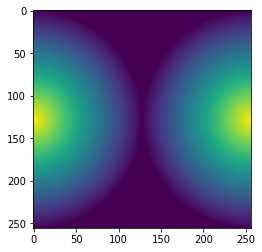

In [6]:
action = (-1, 0, 1, 1, 1, 1)
light_matrix = _action2light(5, action)
plt.imshow(light_matrix.cpu().numpy())
plt.show()

In [ ]:

light_mat = ActiveNematicEnv._action2light(10, action, grid_size=256)
import matplotlib.pyplot as plt
# plt.imshow(light_mat, cmap='gray', alpha=0.5)
# # set the colorbar from 0 to 10
# plt.clim(0, 10)
# plt.colorbar()
# plt.show()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.imshow(light_mat, alpha=0.5)
# set the colorbar from 0 to 10
fig.colorbar(ax.imshow(light_mat, cmap='gray', alpha=1, vmin=0, vmax=10))
# title = 't = ' + str(t)
ax.set_title(str(action))
num_test = 20
# show num_test below x axis
ax.text(-5, -5, str(num_test), ha='center', va='center')
# set x label
ax.set_xlabel('sss'+str(num_test))
# cb = fig.colorbar(ax.imshow(light_mat, cmap='gray', alpha=0.5))
# # set the colorbar from 0 to 10
# cb.set_clim(0, 10)

plt.show()


In [10]:
action = (-5, 0, 1, 1, 1, 1)
action = np.clip(action, -1, 1)
print(action)

[-1  0  1  1  1  1]
